In [23]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, classification_report
from sklearn.tree import DecisionTreeClassifier
import pickle
from pathlib import Path

# May require pip installation
from tqdm.auto import tqdm

from importlib import reload

import sys
sys.path.append("../src")

import utils

In [2]:
plt.rcParams.update({'font.size': 22,
                            'figure.figsize': (12, 8)})
plt.style.use("seaborn")

f_path = Path("../data/bank-full.csv")

df = pd.read_csv(f_path, delimiter=";")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
RANDOM_STATE = 42

import utils
reload(utils)

X_train, X_test, y_train, y_test, scaler = utils.preprocess(df, random_state=RANDOM_STATE)
X_train


,day,campaign,pdays,previous,age_transf,balance_transf,duration_transf,job_blue-collar,job_entrepreneur,job_housemaid,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
41626,25,1,-1,0,1.041921,-0.408664,-0.594750,0,0,0,...,0,0,0,0,0,0,1,0,0,1
31347,16,13,-1,0,-1.218254,-0.296667,-0.680179,0,0,0,...,0,0,1,0,0,0,0,0,0,1
22563,22,1,-1,0,-0.464863,-0.396183,-0.528737,0,0,0,...,0,0,0,0,0,0,0,0,0,1
37243,13,1,-1,0,1.324443,-0.341334,-0.225854,0,1,0,...,0,0,0,1,0,0,0,0,0,1
32259,16,1,339,1,-0.276515,-0.150513,0.399328,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,18,1,-1,0,0.288529,-0.099605,7.124890,0,0,1,...,0,1,0,0,0,0,0,0,0,1
44732,8,1,92,1,-1.689124,-0.280574,-0.187023,0,0,0,...,0,0,0,0,0,0,1,0,0,0
38158,15,1,-1,0,-0.653211,-0.014869,-0.074413,0,0,0,...,0,0,0,1,0,0,0,0,0,1
860,7,1,-1,0,-0.747384,-0.393227,-0.571452,0,0,0,...,0,0,0,1,0,0,0,0,0,1


# Baseline model

In [4]:
%%time
dt = DecisionTreeClassifier(random_state=RANDOM_STATE)
dt.fit(X_train, y_train)

Wall time: 794 ms


DecisionTreeClassifier(random_state=42)

# Drop Low Importance Features

In [5]:
dt.feature_importances_

array([0.08373751, 0.03411881, 0.04604342, 0.01420477, 0.09246333,
       0.12087074, 0.27429252, 0.00711229, 0.00295349, 0.00325963,
       0.00962296, 0.00231843, 0.00487848, 0.00493966, 0.00371305,
       0.00948188, 0.00446896, 0.00153842, 0.01290796, 0.00704915,
       0.00905178, 0.00984232, 0.00475512, 0.00131516, 0.01343555,
       0.00635093, 0.00426076, 0.01636702, 0.00689323, 0.00482121,
       0.00838396, 0.00401968, 0.00894458, 0.01380524, 0.01353193,
       0.0111951 , 0.00791082, 0.0112653 , 0.00836987, 0.00256213,
       0.09108513, 0.00185773])

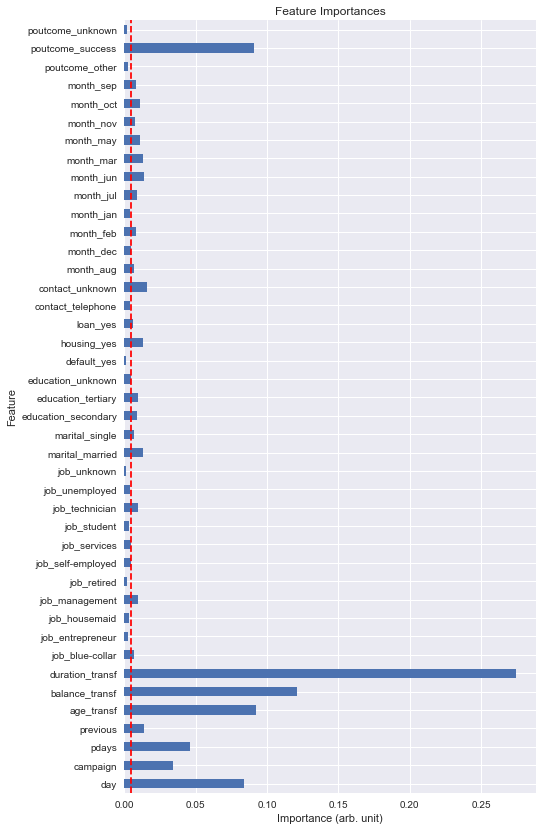

job_entrepreneur     0.002953
job_housemaid        0.003260
job_retired          0.002318
job_self-employed    0.004878
job_services         0.004940
job_student          0.003713
job_unemployed       0.004469
job_unknown          0.001538
education_unknown    0.004755
default_yes          0.001315
contact_telephone    0.004261
month_dec            0.004821
month_jan            0.004020
poutcome_other       0.002562
poutcome_unknown     0.001858
Name: Feature Importances, dtype: float64

In [8]:
reload(utils)
low_features = utils.plot_feature_importances(dt.feature_importances_, X_train.columns, thresh=0.005,
                                              return_low_importance_features=True)
low_features

In [9]:
X_train_drop = X_train.drop(low_features.index, axis=1)
X_test_drop = X_test.drop(low_features.index, axis=1)

In [10]:
%%time
dt_drop = DecisionTreeClassifier(random_state=RANDOM_STATE)
dt_drop.fit(X_train_drop, y_train)

Wall time: 610 ms


DecisionTreeClassifier(random_state=42)

# Hyperparameter Tuning

### First for the original training data X_train

In [11]:
model_base = DecisionTreeClassifier(random_state=RANDOM_STATE)

paramgrid = {'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1,2,3,4,5,6]}


# adboost_paramgrid = {"n_estimators": range(40, 60, 5),
#               "learning_rate": range(1, 2)}

# Use f1 macro score as scoring metric to penalise class imbalance (not needed if SMOTE used)
gs = GridSearchCV(model_base, paramgrid, verbose=True)
gs.fit(X_train, y_train)
dt_gs = gs.best_estimator_

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1080 out of 1080 | elapsed:  3.4min finished


In [12]:
dt_gs

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=5,
                       random_state=42)

### Next for the training data with only important features X_train_drop

In [13]:
gs_drop = GridSearchCV(model_base, paramgrid, verbose=True)
gs_drop.fit(X_train_drop, y_train)
dt_drop_gs = gs_drop.best_estimator_

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=1)]: Done 1080 out of 1080 | elapsed:  1.5min finished


In [14]:
dt_drop_gs

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=5,
                       random_state=42)

**We see that the same hyperparameters are learned and the performance is the same.**

# Oversampling using SMOTE

In [15]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=RANDOM_STATE)
X_train_res_drop, y_train_res_drop = smote.fit_resample(X_train_drop, y_train)

In [16]:
# Using the optimal hyperparameters found from GridSearch on original data X_train
dt_smote = DecisionTreeClassifier(criterion = 'entropy', max_depth = 5, min_samples_leaf = 5, min_samples_split = 2)
dt_smote.fit(X_train_res_drop, y_train_res_drop)

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=5)

# Overview of Decision Tree Model Performance

In [17]:
def predictions(estimator, X_train, X_test, y_train, y_test):
    y_hat_train = estimator.predict(X_train)
    y_hat_test = estimator.predict(X_test)
    return [y_train, y_hat_train, y_test, y_hat_test]

# preds = predictions(dt_clf_base_drop, X_train_res_drop, X_test_drop,\
#                     y_train_res_drop, y_test)

-------------------------------------------------------------------
Baseline


Train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29972
           1       1.00      1.00      1.00      3936

    accuracy                           1.00     33908
   macro avg       1.00      1.00      1.00     33908
weighted avg       1.00      1.00      1.00     33908

Test
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      9950
           1       0.48      0.48      0.48      1353

    accuracy                           0.88     11303
   macro avg       0.70      0.70      0.70     11303
weighted avg       0.88      0.88      0.88     11303

-------------------------------------------------------------------
Baseline + Feature Selection


Train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29972
           1       1.00      1.00      1.0

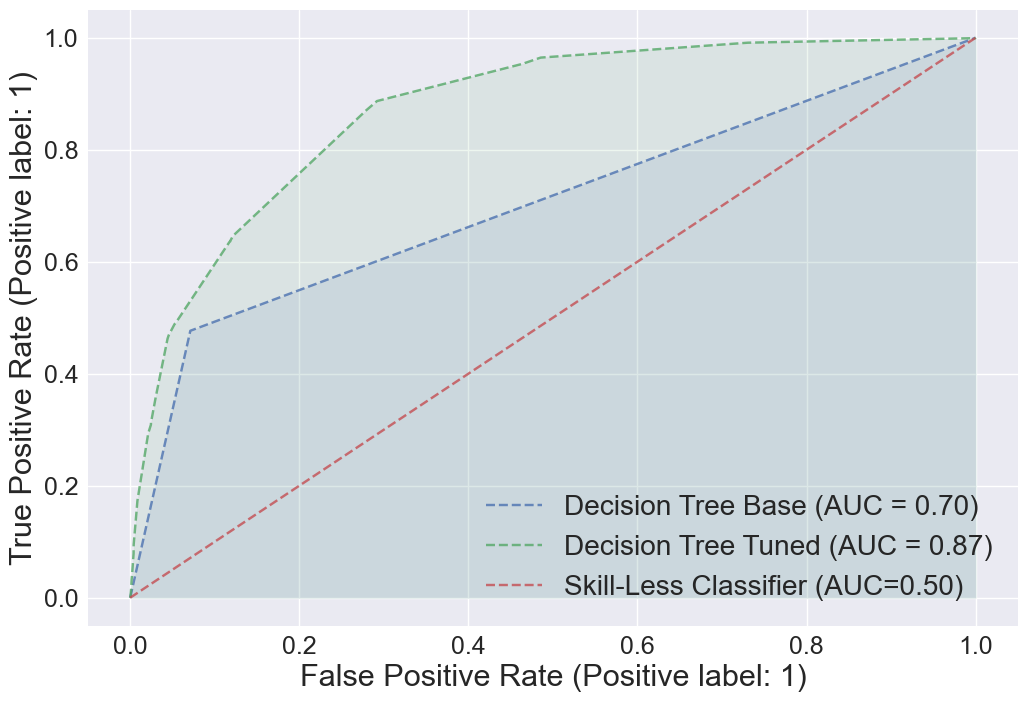

In [41]:
def get_metrics(clfs, X_trains, X_tests, y_trains, y_tests, labels):

    if isinstance(clfs, list):
        for i, clf in enumerate(clfs):
            print('-------------------------------------------------------------------')
            print(' + '.join(label for label in labels[:i+1]))
            print('\n')
#             preds = predictions(clf, X_trains[i], X_tests[i], y_trains[i], y_test[i])
            print('Train')
            print(classification_report(y_trains[i],clf.predict(X_trains[i])))
            print('Test')
            print(classification_report(y_tests[i],clf.predict(X_tests[i])))
clfs = [dt, dt_drop, dt_drop_gs, dt_smote]
X_trains = [X_train, X_train_drop, X_train_drop, X_train_res_drop]
X_tests = [X_test, X_test_drop, X_test_drop, X_test_drop]
y_trains = [y_train, y_train, y_train, y_train_res_drop]
y_tests = [y_test, y_test, y_test, y_test]
labels = ['Baseline', 'Feature Selection', 'GridSearch', 'SMOTE']

get_metrics(clfs, X_trains, X_tests, y_trains, y_tests, labels)
plt.style.use("seaborn")
plots_dir = Path("../plots/decision_tree")

if not plots_dir.is_dir():
    plots_dir.mkdir()
reload(utils)
plt.rcParams.update({'font.size': 14,
                    'axes.labelsize': 22,
                    'xtick.labelsize': 18,
                    'ytick.labelsize': 18})

utils.plot_roc_curve([dt_drop, dt_drop_gs], X_test_drop, y_test,
                    labels=["Decision Tree Base", "Decision Tree Tuned"],
                    subplots_kwargs={"figsize": (12, 8)},
                    save_fpath=plots_dir/"decision_tree_roc.png")

plt.show()

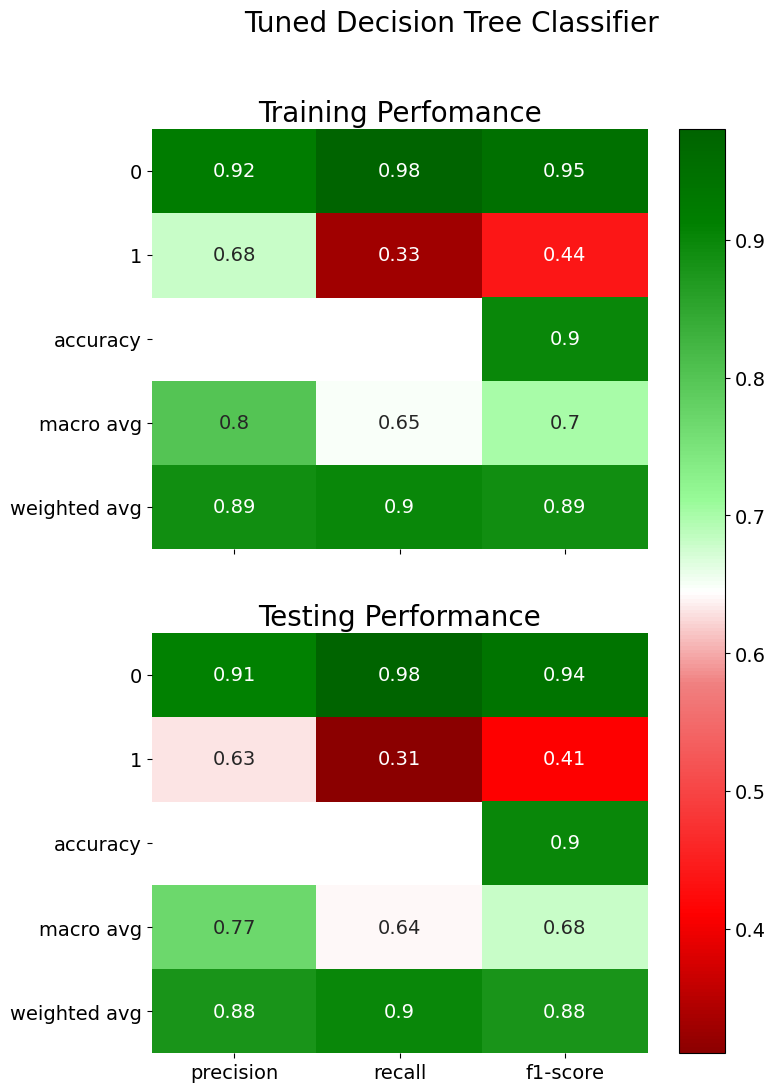

In [39]:
reload(utils)
from matplotlib import pyplot as plt

plt.style.use("default")

plt.rcParams.update({'font.size': 14,
                    'axes.labelsize': 20,
                    'axes.titlesize': 20})

report_df = utils.compare_classification_reports([dt_drop_gs, dt_drop_gs],
                                                 [X_train_drop, X_test_drop],
                                                 [y_train, y_test],
                                                 names=["Training Perfomance", "Testing Performance"],
                                                 suptitle="Tuned Decision Tree Classifier",
                                                 plot=True,
                                                 subplot_kwargs=dict(nrows=2, figsize=(8, 12)),
                                                 cbar_orient="vertical",
                                                  save_fpath=plots_dir/"decision_tree_best_report.png")

**This suggests Baseline + Feature Selection + GridSearch is the best Decision Tree model** (highest accuracy and relatively high F1 score). The Baseline and Baseline + Feature Selection models appear to have overfit.

In [24]:
models_dir = Path("../models/decision_tree")

assert models_dir.is_dir()

data_dir = models_dir/"data"

if not data_dir.is_dir():
    data_dir.mkdir()
    
pickle.dump(dt, open(models_dir/"dt_base.p", "wb"))
pickle.dump(dt_drop, open(models_dir/"dt_drop.p", "wb"))
pickle.dump(dt_drop_gs, open(models_dir/"dt_best.p", "wb"))
pickle.dump(dt_smote, open(models_dir/"dt_drop_res.p", "wb"))
pickle.dump((X_train, X_train_drop, X_train_res_drop, X_test, X_test_drop, y_train, y_train_res_drop, y_test), open(data_dir/"data.p", "wb"))

pickle.dump(low_features, open(models_dir/"low_importance_features.p", "wb"))

with open(models_dir/"README.md", "w") as f:
    f.write(f"""
    ## Adaboost models trained on SMOTE resampled data
    Contents:
    - `dt_base.p` - trained DecisionTreeClassifier instance (baseline classifier)
    - `dt_drop.p` - trained DecisionTreeClassifier instance (baseline classifier with dropped features)
    - `dt_best.p` - trained DecisionTreeClassifier instance (best classifier)
    - `dt_drop_res.p` - trained DecisionTreeClassifier instance (baseline classifier with dropped features and SMOTE)
    - `data.p` - data tuple (X_train, X_train_drop, X_train_res_drop, X_test, X_test_drop, y_train, y_train_res_drop, y_test)
    - `low_importance_features.p` - pd Series of low importance features
    The following low importance features have been dropped:
    {str(low_features.index.values)}
    """)